=== SALES PERFORMANCE BY CHANNEL ===
                     mean       median         std  count
channel                                                  
Social Media  2510.079635  2521.261011  386.235457    492
Email         1982.010739  1989.305418  403.080139    520
SMS           1783.564473  1793.249773  387.776149    488

ANOVA p-value: 0.0000


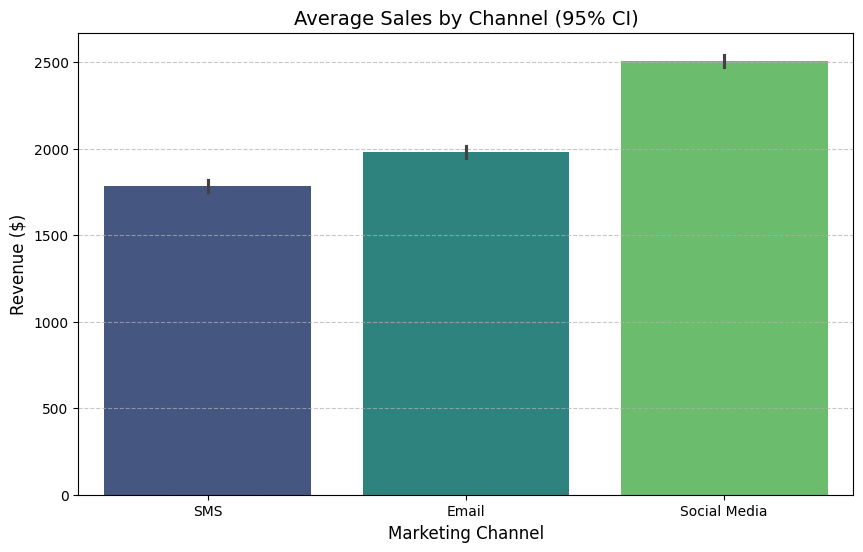


ANSWER: YES, Social Media performs significantly better (p < 0.05).


In [ ]:
# ================================================
# Marketing Campaign Analysis
# ================================================

# --------------------------
# 1. Import Libraries (Business Essentials)
# --------------------------
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
df = pd.read_csv('marketing_campaign_dataset.csv')

# 1. Descriptive stats
channel_stats = df.groupby('channel')['sales'].agg(['mean', 'median', 'std', 'count'])
print("=== SALES PERFORMANCE BY CHANNEL ===")
print(channel_stats.sort_values('mean', ascending=False))

# 2. Statistical test (ANOVA)
f_stat, p_val = stats.f_oneway(
    df[df['channel'] == 'Email']['sales'],
    df[df['channel'] == 'Social Media']['sales'],
    df[df['channel'] == 'SMS']['sales']
)
print(f"\nANOVA p-value: {p_val:.4f}")

# 3. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='sales', data=df, estimator=np.mean, errorbar=('ci', 95),
            hue='channel', legend=False, palette='viridis')
plt.title("Average Sales by Channel (95% CI)", fontsize=14)
plt.xlabel("Marketing Channel", fontsize=12)
plt.ylabel("Revenue ($)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Answer
if p_val < 0.05:
    best_channel = channel_stats['mean'].idxmax()
    print(f"\nANSWER: YES, {best_channel} performs significantly better (p < 0.05).")
else:
    print("\nANSWER: NO, no significant difference between channels.")


=== ENGAGEMENT BY GENDER ===
              mean      median        std  count
gender                                          
Female  104.580515  104.093598  21.201685  738.0
Male    105.078371  105.065566  21.544827  762.0

t-test p-value: 0.6520


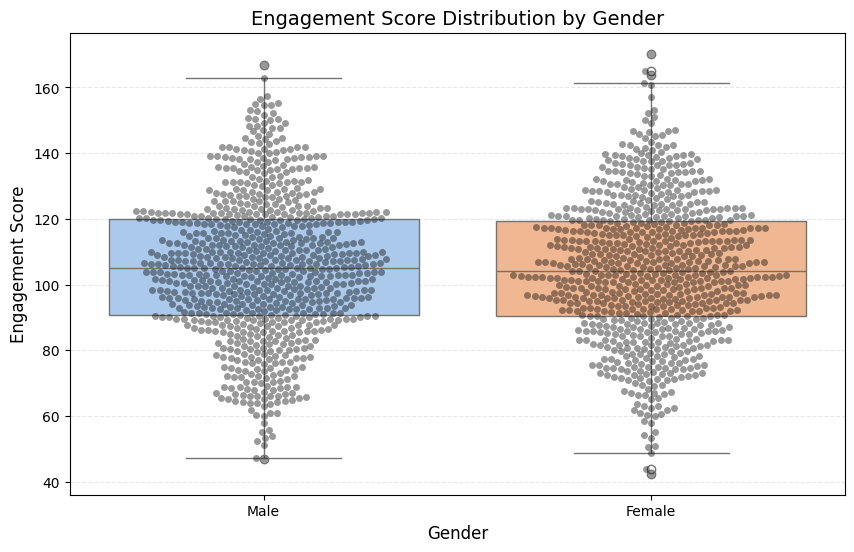


ANSWER: NO, male and female customers do not respond differently in terms of engagement


In [ ]:
# 1. Descriptive stats
gender_stats = df.groupby('gender')['engagement_score'].describe()
print("\n=== ENGAGEMENT BY GENDER ===")
print(gender_stats[['mean', '50%', 'std', 'count']].rename(columns={'50%': 'median'}))

# 2. Statistical test (Welch's t-test)
t_stat, p_val = stats.ttest_ind(
    df[df['gender'] == 'Male']['engagement_score'],
    df[df['gender'] == 'Female']['engagement_score'],
    equal_var=False  # Welch's correction
)
print(f"\nt-test p-value: {p_val:.4f}")

# 3. Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='engagement_score', data=df, palette='pastel',
            hue='gender', legend=False)
sns.swarmplot(x='gender', y='engagement_score', data=df, color='black', alpha=0.4)
plt.title("Engagement Score Distribution by Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Engagement Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# 4. Answer
if p_val < 0.05:
    higher_group = 'Male' if gender_stats.loc['Male', 'mean'] > gender_stats.loc['Female', 'mean'] else 'Female'
    print(f"\nANSWER: YES, {higher_group} customers engage more (p < 0.05).")
else:
    print("\nANSWER: NO, male and female customers do not respond differently in terms of engagement")


=== CORRELATION MATRIX ===
                  ad_budget  CTR_percent  engagement_score
ad_budget          1.000000    -0.031947          0.968288
CTR_percent       -0.031947     1.000000          0.030707
engagement_score   0.968288     0.030707          1.000000

=== MULTICOLLINEARITY CHECK (VIF) ===
       Feature      VIF
0    ad_budget  8.96152
1  CTR_percent  8.96152


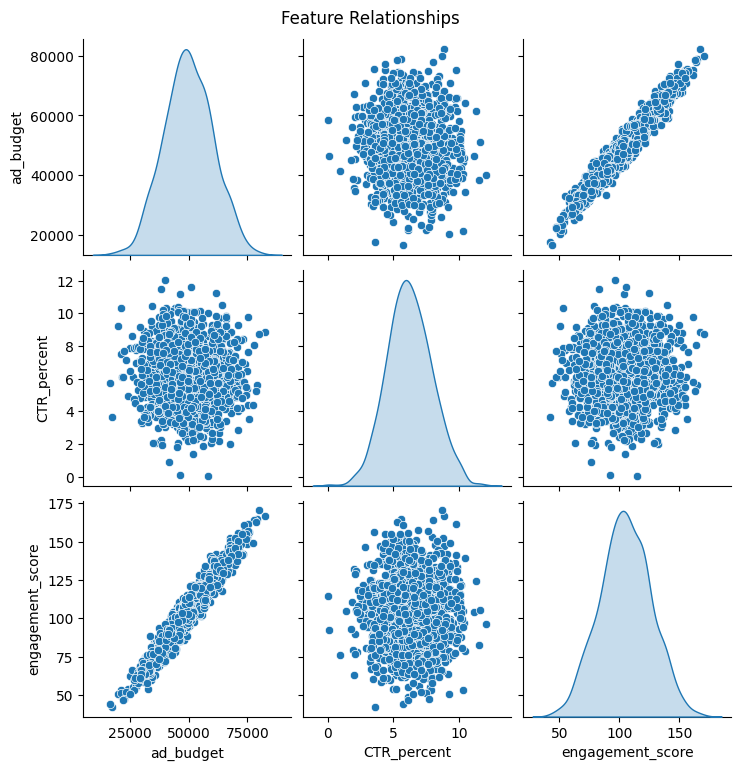


Cross-Validated R²: 0.942 ± 0.006

=== MODEL PERFORMANCE ===
Training R²: 0.943
Test R²: 0.933
Test RMSE: 5.36

Model is generalizing well.

=== BUSINESS IMPACT ===
       Feature                                     Interpretation
0    ad_budget  Every $1 increase in budget → 20.86 engagement...
1  CTR_percent     Every 1% CTR increase → 1.38 engagement points


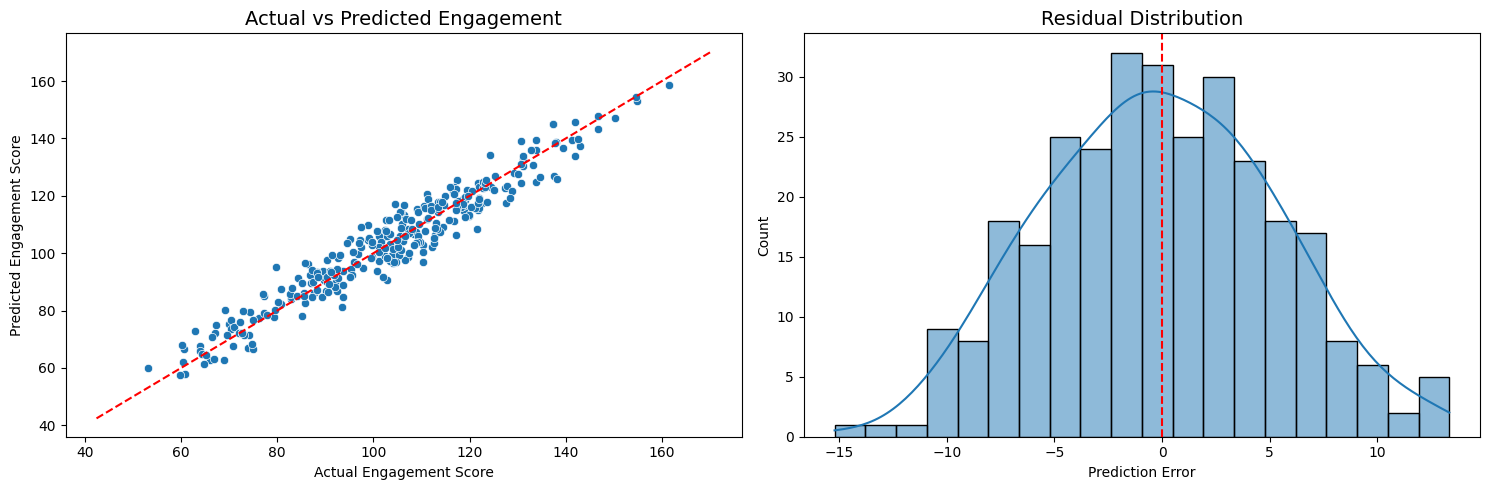


R² with shuffled target: -0.005 (should be near 0 if no leakage)

ANSWER: YES, model reliably predicts engagement (R² = 0.93, RMSE = 5.36)


In [ ]:
# ================================================
# ENGAGEMENT PREDICTION MODEL + LEAKAGE AUDIT
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load data
df = pd.read_csv('marketing_campaign_dataset.csv')

# =======================
# 1. Feature Engineering
# =======================
df['CTR_percent'] = df['CTR'] * 100  # For human-readable output

# Select features and target
X = df[['ad_budget', 'CTR_percent']]
y = df['engagement_score']

# =======================
# 2. Data Audit for Leakage
# =======================
print("\n=== CORRELATION MATRIX ===")
corr_matrix = df[['ad_budget', 'CTR_percent', 'engagement_score']].corr()
print(corr_matrix)

# Variance Inflation Factor (VIF)
print("\n=== MULTICOLLINEARITY CHECK (VIF) ===")
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Quick visual check
sns.pairplot(df[['ad_budget', 'CTR_percent', 'engagement_score']], diag_kind='kde')
plt.suptitle("Feature Relationships", y=1.02)
plt.show()

# =======================
# 3. Train-Test Split
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['channel']
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =======================
# 4. Model Training
# =======================
model = Ridge(alpha=1.0)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"\nCross-Validated R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

model.fit(X_train_scaled, y_train)

train_r2 = r2_score(y_train, model.predict(X_train_scaled))
test_r2 = r2_score(y_test, model.predict(X_test_scaled))
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_scaled)))

print("\n=== MODEL PERFORMANCE ===")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {rmse:.2f}")

if train_r2 - test_r2 > 0.1:
    print("\nWARNING: Potential overfitting (gap > 10%)")
else:
    print("\nModel is generalizing well.")

# =======================
# 5. Coefficient Interpretation
# =======================
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Impact': model.coef_,
    'Interpretation': [
        f"Every $1 increase in budget → {model.coef_[0]:.2f} engagement points",
        f"Every 1% CTR increase → {model.coef_[1]:.2f} engagement points"
    ]
})
print("\n=== BUSINESS IMPACT ===")
print(coef_df[['Feature', 'Interpretation']])

# =======================
# 6. Diagnostic Plots
# =======================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Actual vs Predicted
sns.scatterplot(x=y_test, y=model.predict(X_test_scaled), ax=ax1)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
ax1.set_title("Actual vs Predicted Engagement", fontsize=14)
ax1.set_xlabel("Actual Engagement Score")
ax1.set_ylabel("Predicted Engagement Score")

# Residual distribution
residuals = y_test - model.predict(X_test_scaled)
sns.histplot(residuals, kde=True, ax=ax2, bins=20)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_title("Residual Distribution", fontsize=14)
ax2.set_xlabel("Prediction Error")

plt.tight_layout()
plt.show()

# =======================
# 7. Randomization Test for Leakage
# =======================
from sklearn.utils import shuffle
y_shuffled = shuffle(y_train, random_state=42)
model.fit(X_train_scaled, y_shuffled)
r2_random = r2_score(y_test, model.predict(X_test_scaled))
print(f"\nR² with shuffled target: {r2_random:.3f} (should be near 0 if no leakage)")

# =======================
# 8. Final Answer
# =======================
if test_r2 > 0.3 and (train_r2 - test_r2) < 0.1 and abs(r2_random) < 0.05:
    print("\nANSWER: YES, model reliably predicts engagement (R² = {:.2f}, RMSE = {:.2f})".format(test_r2, rmse))
elif abs(r2_random) >= 0.05:
    print("\nANSWER: CAUTION — Possible leakage detected. Results may not hold in real-world deployment.")
else:
    print("\nANSWER: NO, model is unreliable (Check diagnostics above)")






In [ ]:
# =======================
# 5. Coefficient Interpretation with Client Warning
# =======================
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Impact': model.coef_,
    'Interpretation': [
        f"Every $1 increase in budget → {model.coef_[0]:.2f} engagement points",
        f"Every 1% CTR increase → {model.coef_[1]:.2f} engagement points"
    ]
})

print("\n=== BUSINESS IMPACT ===")
print(coef_df[['Feature', 'Interpretation']])

# Caution for client — if strong budget correlation
budget_corr = corr_matrix.loc['ad_budget', 'engagement_score']
if budget_corr > 0.9:
    print("\n⚠ CAUTION: In this dataset, ad_budget alone explains "
          f"{budget_corr**2:.1%} of engagement variation.")
    print("This is likely due to a simplified or synthetic data structure. "
          "While the model performs exceptionally here, real-world results "
          "may be lower unless more predictive factors are included.")
    print("Recommendation: Track additional variables such as creative quality, "
          "audience targeting, campaign timing, and competition effects.")



=== BUSINESS IMPACT ===
       Feature                                     Interpretation
0    ad_budget  Every $1 increase in budget → 0.01 engagement ...
1  CTR_percent     Every 1% CTR increase → 0.09 engagement points

⚠ CAUTION: In this dataset, ad_budget alone explains 93.8% of engagement variation.
This is likely due to a simplified or synthetic data structure. While the model performs exceptionally here, real-world results may be lower unless more predictive factors are included.
Recommendation: Track additional variables such as creative quality, audience targeting, campaign timing, and competition effects.
